In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import norm, bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df

In [8]:
# Reading in data

hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv")
hoyle_data = (
    hoyle_data[hoyle_data["task"]=="intrusions"]
    .drop(columns=[c for c in hoyle_data.columns if c[1]=="_"])
    .rename(columns={"dataset":"corpus", "topic_idx":"topic",
                     "human_idx":"rater", "scores_raw":"intrusion",
                     "confidences_raw":"confidence"})
    ).drop(columns=["task"])

In [9]:
corpus_ids = (hoyle_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (hoyle_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (hoyle_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

# topic_ids = (hoyle_data.groupby(["corpus", "model", "topic"], as_index=False)
#     .agg({"intrusion":"count"})
#     .drop(columns="intrusion"))
# topic_ids["topic_id"] = topic_ids.index 

rater_ids = (hoyle_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(hoyle_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
# Topic ids are no longer 0 - 299
# data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = d4.rename(columns={"topic" : "topic_id"})
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

## Calculating S.D. of measured p's

[]

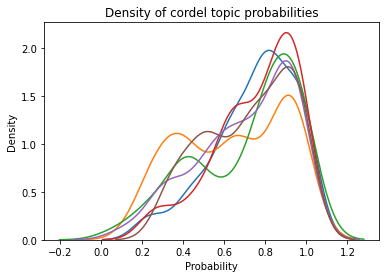

In [10]:
test=data.groupby(["cordel_id", "topic_id"]).agg({"intrusion":"mean"}).reset_index()
for c in range(6):
    sns.kdeplot(test[test["cordel_id"]==c]["intrusion"], bw_adjust=0.8)
plt.title("Density of cordel topic probabilities")
plt.xlabel("Probability")
plt.plot()

# Looks probabilities are left skewed. Many topics are close to 1

In [11]:
# Changing probabilities to log odds
logit_data = data.groupby(["cordel_id", "topic_id"]).agg({"intrusion":"mean"}).reset_index()
logit_data["intrusion"] = logit_data["intrusion"].apply(logit)
logit_data[logit_data["intrusion"]==np.inf]=4

In [12]:
# Finding empical mean/sd of log odds
cordel_logodds_std = logit_data.groupby("cordel_id").agg({"intrusion":"std"}).reset_index() \
        ["intrusion"].mean()
cordel_logodds_mean = logit_data.groupby("cordel_id").agg({"intrusion":"mean"}).reset_index() \
        ["intrusion"].mean()
print("average std of cordel topic log odds", cordel_logodds_std)
print("average topic log odds", cordel_logodds_mean)

average std of cordel topic log odds 1.3647803740693865
average topic log odds 1.234662859641615


[]

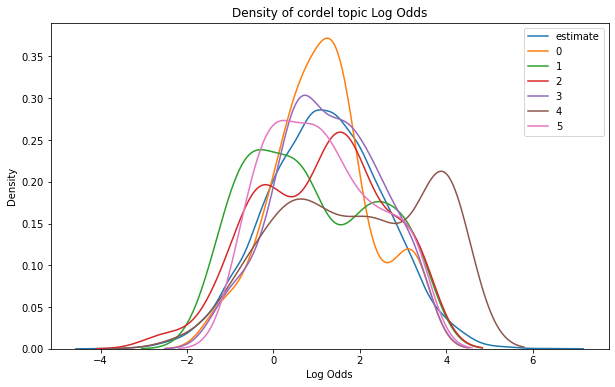

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10,6))


sns.kdeplot(norm.rvs(loc=cordel_logodds_mean, scale=cordel_logodds_std, size=10000))
for c in range(6):
    sns.kdeplot(logit_data[logit_data["cordel_id"]==c]["intrusion"], bw_adjust=0.8, ax=ax)

    

ax.legend(ax.get_lines(), ["estimate"]+[f"{i}" for i in range(6)])
plt.title("Density of cordel topic Log Odds")
plt.xlabel("Log Odds")
plt.plot()

# Much more symmetric

[]

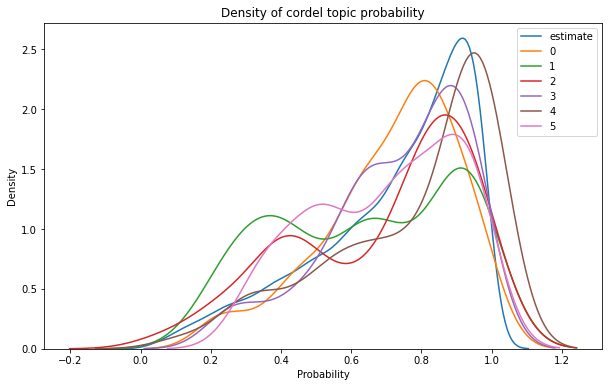

In [53]:
_, ax = plt.subplots(1, 1, figsize=(10,6))


sns.kdeplot([expit(x) for x  in norm.rvs(loc=cordel_logodds_mean, scale=cordel_logodds_std, size=10000)])
for c in range(6):
    sns.kdeplot(logit_data[logit_data["cordel_id"]==c]["intrusion"].apply(expit), bw_adjust=0.8, ax=ax)

    

ax.legend(ax.get_lines(), ["estimate"]+[f"{i}" for i in range(6)])
plt.title("Density of cordel topic probability")
plt.xlabel("Probability")
plt.plot()

# Looks like a reasonable fit

## Functions

In [2]:
def simulate_scores(logodds_loc_1, logodds_loc_2, n_ratings):
# Generates a set of scores given the distribution mean of topics and number of ratings
    sample = data.drop(index=range(len(data)))
    return 

In [28]:
model_1_topic_ps

array([0.38562013, 0.80578243, 0.3389448 , 0.47464883, 0.77420748,
       0.34587962, 0.82713517, 0.74889015, 0.78000425, 0.93135541,
       0.9615634 , 0.97054789, 0.64897552, 0.60155478, 0.61787673,
       0.21775083, 0.053626  , 0.8871614 , 0.3743637 , 0.80671291,
       0.88271499, 0.37828959, 0.94418546, 0.2134606 , 0.91573155,
       0.85186138, 0.51166365, 0.44958842, 0.46473832, 0.25676863,
       0.88991557, 0.91066654, 0.73237348, 0.49222105, 0.80577713,
       0.84758384, 0.39717483, 0.56933865, 0.83278243, 0.83286101,
       0.92701106, 0.38947129, 0.90337393, 0.82460805, 0.55943826,
       0.45921085, 0.44871722, 0.30912695, 0.66135517, 0.86608344])

In [52]:
n_ratings = 20
logodds_loc_1 = logit(0.7)
logodds_loc_2 = logit(0.8)

# Generates 50 topics with p~N(dist_1_loc, empirical_sd)
# For each topic, generate n_ratings s~bernoulli(p)
sample = data.drop(index=range(len(data)))

model_1_topic_ps = expit(norm.rvs(loc=logodds_loc_1, scale=cordel_logodds_std, size=50))
model_2_topic_ps = expit(norm.rvs(loc=logodds_loc_2, scale=cordel_logodds_std, size=50))

for p in model_1_topic_ps:
    scores = bernoulli.rvs(p, size=n_ratings)

    print(p)
    print(scores.sum()/20)
    break






0.7372406400406839
0.75


In [30]:
def is_utest_sig(sample):
# Utests whether the two distributions in the sample are statisticaly significant
    test_result = True
    return  test_result

In [4]:
def is_bht_sig(sample):
# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
    test_result = True
    return  test_result

In [7]:
# Simulation setup

sims_per_setting = 10
p_diff = np.geomspace(0.02, 0.2, num=10)
n_ratings = np.array(range(5, 55, 5))
empirical_mean = 0.75

utest_results = {}
bht_results = {}

for p in p_diff:
    for n in n_ratings:
        utest_results[p,n]=0
        bht_results[p,n]=0

In [45]:
# Simulation loop

for p in p_diff:
    for n in n_ratings:
        utest_sigs = 0
        bht_sigs = 0
        for _ in range(sims_per_setting):
            mean_1 = empirical_mean - p/2
            mean_2 = empirical_mean + p/2
            
            s = simulate_scores(mean_1, mean_2, n)
            utest_sigs += is_utest_sig(s)
            bht_sigs += is_bht_sig(s)
        utest_results[p,n] = utest_sigs/sims_per_setting
        bht_results[p,n] = bht_sigs/sims_per_setting
            